In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#from helpers.plot_helpers import *
import cmocean
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 3

# Default matplotlib plotting parameters

In [2]:
import matplotlib
def default_rcParams(kw={}):
    '''
    Also matplotlib.rcParamsDefault contains the default values,
    but:
    - backend is changed
    - without plotting something as initialization,
    inline does not work
    '''
    plt.plot()
    plt.close()
    rcParams = matplotlib.rcParamsDefault.copy()
    
    # We do not change backend because it can break
    # inlining; Also, 'backend' key is broken and 
    # we cannot use pop method
    for key, val in rcParams.items():
        if key != 'backend':
            rcParams[key] = val

    matplotlib.rcParams.update({
        'font.family': 'MathJax_Main',
        'mathtext.fontset': 'cm',

        'figure.figsize': (4, 4),

        'figure.subplot.wspace': 0.3,
        
        'font.size': 14,
        #'axes.labelsize': 10,
        #'axes.titlesize': 12,
        #'xtick.labelsize': 10,
        #'ytick.labelsize': 10,
        #'legend.fontsize': 10,

        'axes.formatter.limits': (-2,3),
        'axes.formatter.use_mathtext': True,
        'axes.labelpad': 0,
        'axes.titlelocation' : 'center',
        
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })
    matplotlib.rcParams.update(**kw)

# Gulf stream path is along isolines

In [5]:
def sort_longitude(x):
    x['lon'] = np.where(x['lon']>0, x['lon'], 360+x['lon'])
    x = x.sortby('lon')
    return x
def regrid_to_1x1(sst_R4, lon, lat):
    # Coarse with grid box 4x4
    sst_R1 = sst_R4.coarsen({'xh':4, 'yh':4}, boundary='trim').mean()
    # Rename coordinates:
    sst_R1 = sst_R1.rename({'xh':'lon', 'yh':'lat'})
    # Sort coordinates:
    sst_R1 = sort_longitude(sst_R1)
    # Interpolate to WOA grid
    sst_R1 = sst_R1.interp({'lon': lon, 'lat': lat})
    return sst_R1.compute()

In [13]:
# Read WOA data
woa = sort_longitude(xr.open_dataset('/vast/pp2681/WOA/woa_1981_2010.nc', decode_times=False).t_an.sel(depth=175).isel(time=0))

In [23]:
'''
Read simulation data:
* Average over 3 years at the surface
* Adjust coordinate names
* Coarsen to 1x1 grid
* Adjust NaN values
'''
# Read simulation data:
# Average over 3 years, coarsen to 1x1 grid, adjust
# coordinate names
selector = lambda file_path: xr.where(np.isnan(woa), np.nan,
                             regrid_to_1x1(
                             xr.open_mfdataset(file_path).thetao.sel(z_l=156.25).isel(time=slice(-36,None)).mean('time'), 
                             woa.lon, woa.lat).compute())

In [24]:
om4 = selector('/scratch/pp2681/mom6/OM4_SIS2/unparameterized/output/*ocean_month_z*')

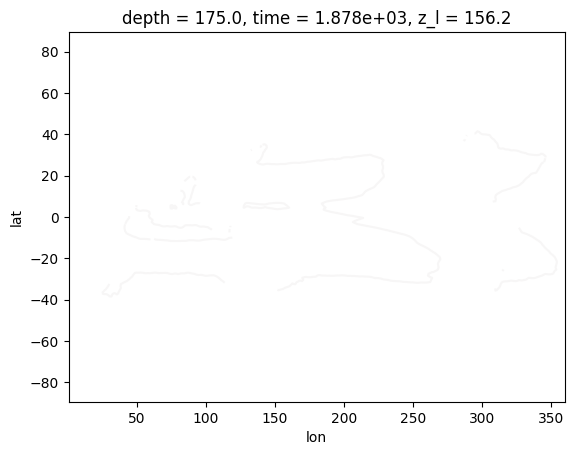

In [29]:
om4.plot.contour(levels=[-1e+20,17,1e+20])

Text(0.5, 1.0, '$1/4^\\circ$ OM4 ocean model')

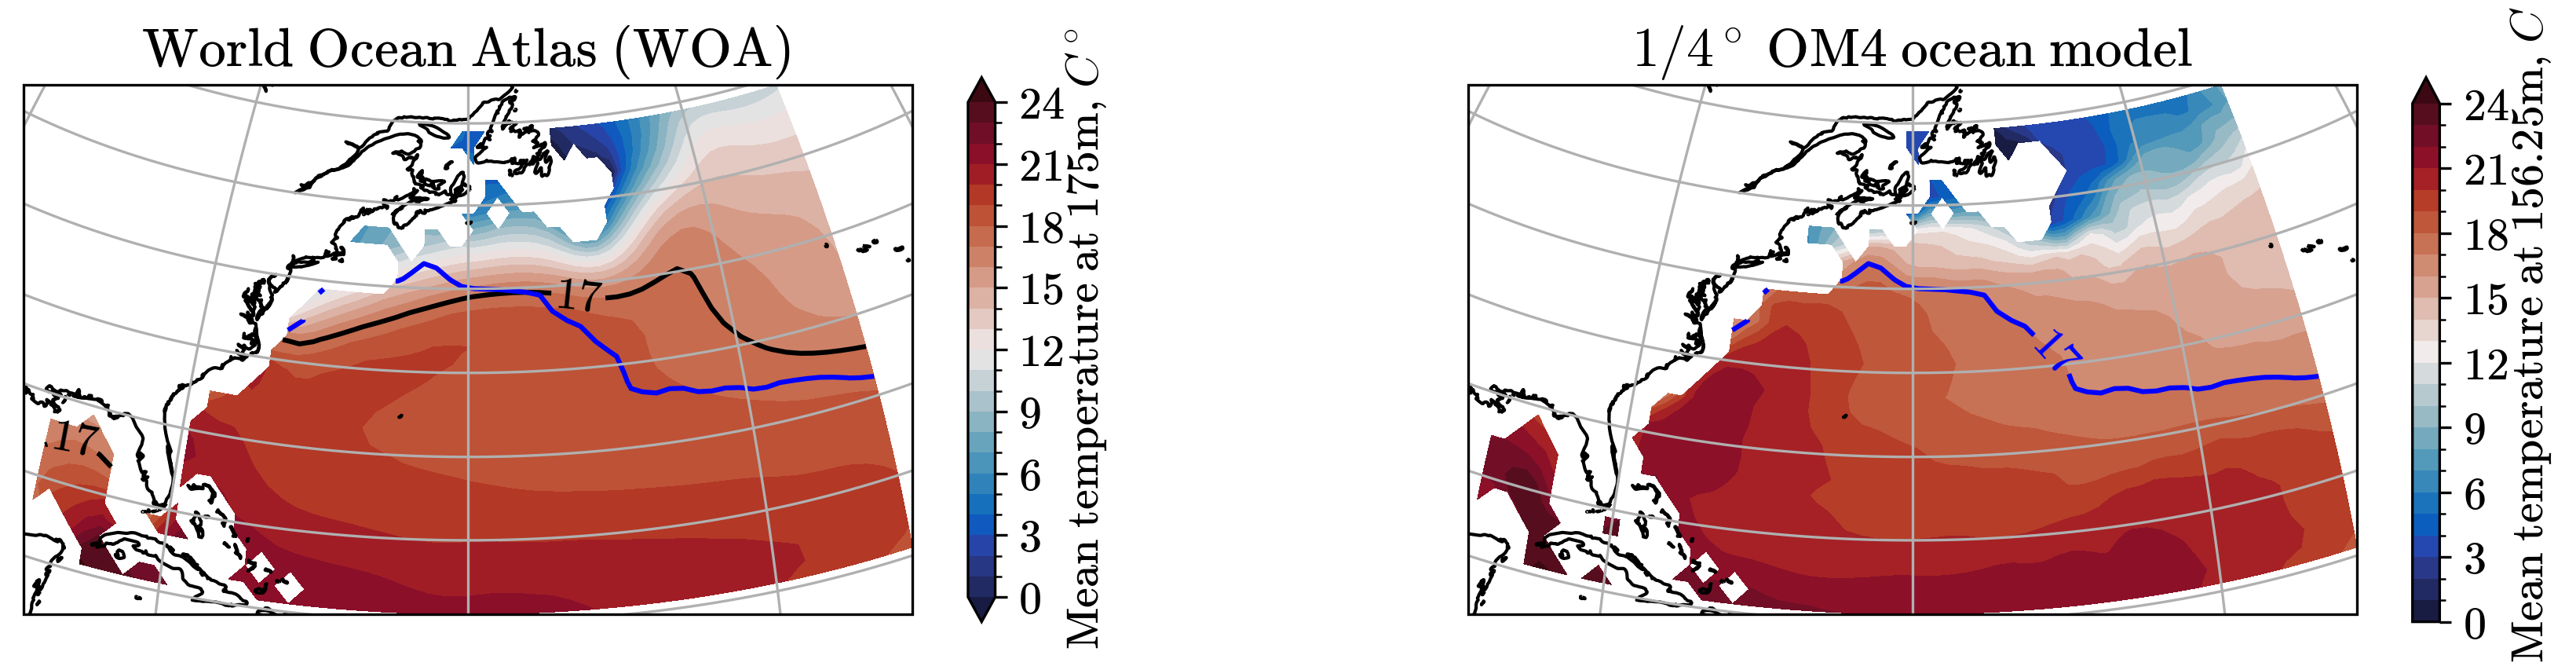

In [93]:
default_rcParams()
lat=slice(20,50); lon=slice(270,330)
fig, axes = plt.subplots(1,2, figsize=(14, 3), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)}, dpi=300)
cmap = cmocean.cm.balance
cmap.set_bad('gray')

woa.sel(lat=lat,lon=lon).plot.contourf(ax=axes[0], levels=np.arange(0,25), transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': "  Mean temperature at 175m, $C^\circ$"})
CS = woa.sel(lat=lat,lon=lon).plot.contour(ax=axes[0], levels=[-100,17,100], transform=ccrs.PlateCarree(), colors='k')
axes[0].clabel(CS, CS.levels, inline=True, fontsize=14)
om4.sel(lat=lat,lon=lon).plot.contourf(ax=axes[1], levels=np.arange(0,25), transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': "       Mean temperature at 156.25m, $C^\circ$"})
CS = om4.sel(lat=lat,lon=lon).plot.contour(ax=axes[1], levels=[-100,17,100], transform=ccrs.PlateCarree(), colors='b')
axes[1].clabel(CS, CS.levels, inline=True, fontsize=14)
om4.sel(lat=lat,lon=lon).plot.contour(ax=axes[0], levels=[-100,17,100], transform=ccrs.PlateCarree(), colors='b')
axes[0].coastlines()
axes[0].gridlines()

axes[1].coastlines()
axes[1].gridlines()

axes[0].set_title('World Ocean Atlas (WOA)')
axes[1].set_title('$1/4^\circ$ OM4 ocean model')